# part0: imports

In [4]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal
import defs

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)
    reload(defs)


read data

In [5]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

preprocessing

In [6]:
def plot_colored_line(ax, x, y, colors = None):
    """
    based on this:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html?highlight=multicolored_line
    """
    if colors is None:
        colors = utility.get_colors(x.shape[0])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, colors=colors)

    lc.set_array(y)
    line = ax.add_collection(lc)
    ax.set_ylim([y.min(),y.max()])
    ax.set_xlim([x.min(),x.max()])
    
    return ax

def plot_3d_colored_line(ax, x, y, z, colors = None, **kwargs):
    """
    based on this:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html?highlight=multicolored_line
    """
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    
    if colors is None:
        colors = utility.get_colors(x.shape[0])

    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = Line3DCollection(segments, colors=colors, **kwargs)

    lc.set_array(z)
    line = ax.add_collection(lc)
    ax.set_ylim([y.min(),y.max()])
    ax.set_xlim([x.min(),x.max()])
    ax.set_zlim([z.min(),z.max()])
    
    return ax

## Plot FR rasters

In [125]:
# redefine exec epoch
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=-1,
                                     rel_end=10)

In [126]:
raster_example = (AllDFs[4], AllDFs[1])
raster_example_df = []
for df in raster_example:
    df = pyal.restrict_to_interval(df, epoch_fun=exec_epoch)
    df = pyal.remove_low_firing_neurons(df, 'M1_rates', 1)
    raster_example_df.append(df)

min_units = min([df.M1_rates[0].shape[1] for df in raster_example_df])

/home/msafaie/REPOS/MyPyalData/pyaldata/firing_rates.py:92: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings.warn("Assuming rates are already in Hz and don't have to divide by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/firing_rates.py:92: UserWarning: Assuming rates are already in Hz and don't have to divide by bin size.
  utils.warnings.warn("Assuming rates are already in Hz and don't have to divide by bin size.")


Text(0, 0, 'Time rel. movement onset')

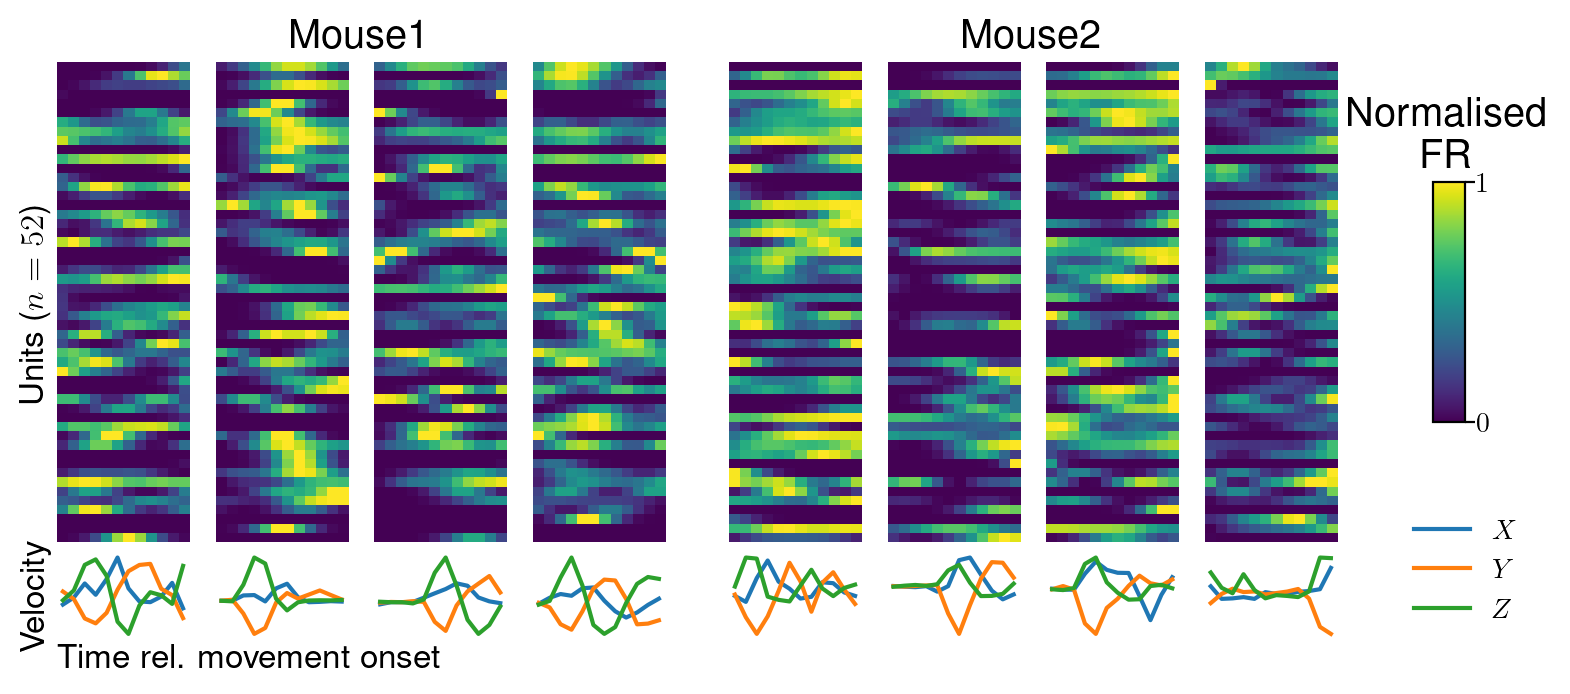

In [127]:
fig = plt.figure(figsize=(8,6), dpi=100)
gs1   =fig.add_gridspec(nrows=1, ncols=4, left=0.1, bottom=0.4, right=.48, top=.8)
gs2   =fig.add_gridspec(nrows=1, ncols=4, left=.52, bottom=0.4, right=.9, top=.8)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.96, bottom=0.5, right=.98, top=.7)
cax = fig.add_subplot(gs_c[:])

trial=2

axes = []
for i,df in enumerate(raster_example_df):
    data = []
    for tar in range(4):
        df_ = pyal.select_trials(df, df.target_id==tar)
        fr = df_.M1_rates[trial]
        data.append(fr[:,:min_units])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))
    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[i][j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

axes[0].set_ylabel(f'Units ($n={min_units}$)')
fig.colorbar(cm.ScalarMappable(),cax=cax, ticks=(0,1),drawedges=False)
cax.set_title('Normalised\nFR')
ax = utility.phantom_axes(fig.add_subplot(gs1[:]))
ax.set_title('Mouse1')
ax = utility.phantom_axes(fig.add_subplot(gs2[:]))
ax.set_title('Mouse2')

#========================
gs1   =fig.add_gridspec(nrows=1, ncols=4, left=0.1, bottom=0.32, right=.48, top=.39)
gs2   =fig.add_gridspec(nrows=1, ncols=4, left=.52, bottom=0.32, right=.9, top=.39)
gs = [gs1,gs2]

axes = []
for i,df in enumerate(raster_example_df):
    for tar in range(4):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.hVelB[trial]
        ax = fig.add_subplot(gs[i][tar])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.plot(data[:,2], label='$Z$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

axes[0].set_ylabel('Velocity')
axes[-1].legend(frameon=False, loc=(1.5,0.04))
axes[0].set_xlabel('Time rel. movement onset',loc='left')

## plot 3D trajectories, single trial per target

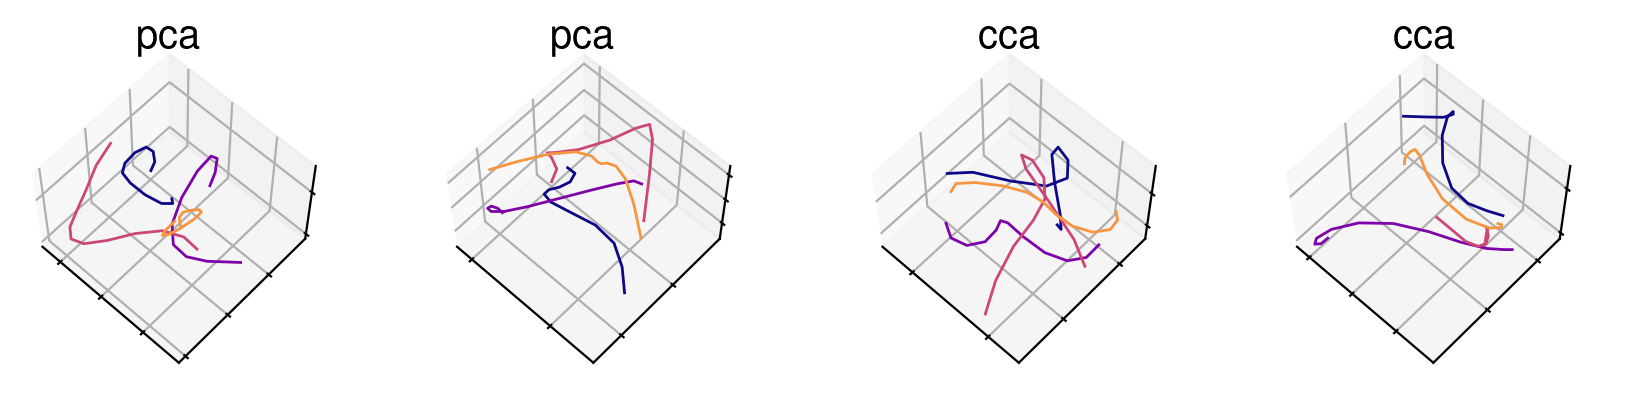

In [137]:
fig = plt.figure(figsize=(10,3), dpi=100)
gs1   =fig.add_gridspec(nrows=1, ncols=2, left=0.1, bottom=0.4, right=.48, top=.9)
gs2   =fig.add_gridspec(nrows=1, ncols=2, left=.52, bottom=0.4, right=.9, top=.9)
gs = [gs1,gs2]
# gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.94, bottom=0.55, right=.96, top=.7)
# cax = fig.add_subplot(gs_c[:])
colors = utility.get_colors(4)

trial=7

dfs=[]
for i,df in enumerate(raster_example_df):
    rates = np.concatenate(df['M1_rates'].values, axis=0)
    rates -= np.mean(rates, axis=0)
    rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
    dfs.append(df_)
    ax = fig.add_subplot(gs[0][i], projection='3d',fc='None')
    ax.set_title('pca')
    axes.append(ax)
    for tar in range(4):
        df__ = pyal.select_trials(df_, df_.target_id==tar)
        ex = df__._pca[trial][:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.set_xticklabels([])          # removes the ticks... great now the rest of it
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.view_init(60,-47)

AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
data1 = np.reshape(AllData[0,...], (-1,10))
data2 = np.reshape(AllData[1,...], (-1,10))
A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
coef_ = [A,B]
for i,sessionData in enumerate(AllData):
    ax = fig.add_subplot(gs[1][i], projection='3d',fc='None')
    ax.set_title('cca')
    axes.append(ax)
    for tar in range(4):
        ex = sessionData[tar,trial,...]
        ex = ex @ coef_[i]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.set_xticklabels([])          # removes the ticks... great now the rest of it
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.view_init(60,-47)


the above plotting of a single trial to each target does not show higher correlations as I had hoped

---

## plot 3D trajectories, target averaged

(-1.265, 1.265)

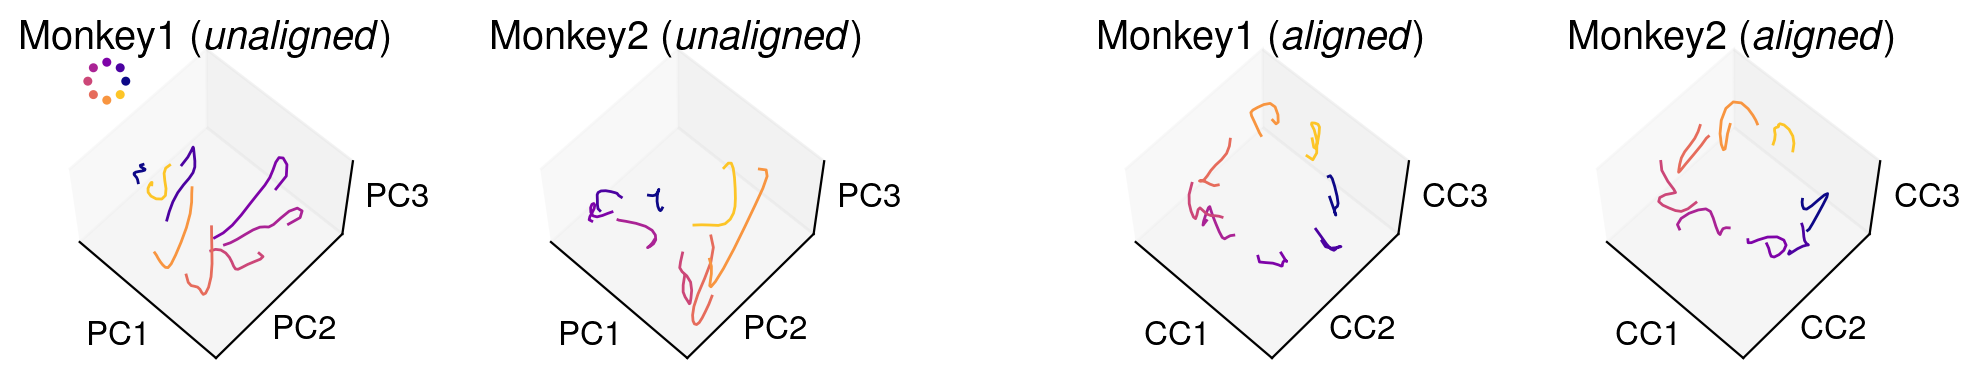

In [10]:
fig = plt.figure(figsize=(12,3), dpi=100)
gs1   =fig.add_gridspec(nrows=1, ncols=2, left=0.1, bottom=0.4, right=.46, top=.9)
gs2   =fig.add_gridspec(nrows=1, ncols=2, left=.54, bottom=0.4, right=.9, top=.9)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.13, bottom=0.82, right=.15, top=.9, wspace=0, hspace=0)
cax = fig.add_subplot(gs_c[0],zorder=10)

colors = utility.get_colors(8)
dfs=[]
axes=[]
for i,df in enumerate(raster_example_df):
    rates = np.concatenate(df['M1_rates'].values, axis=0)
    rates -= np.mean(rates, axis=0)
    rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
    dfs.append(df_)
    ax = fig.add_subplot(gs[0][i], projection='3d',fc='None')
    ax.set_title('pca')
    axes.append(ax)
    for tar in range(8):
        df__ = pyal.select_trials(df_, df_.target_id==tar)
        ex = pyal.get_sig_by_trial(df__,'_pca')
        ex = np.mean(ex, axis=2)[:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.view_init(60,-47)

AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
data1 = np.reshape(AllData[0,...], (-1,10))
data2 = np.reshape(AllData[1,...], (-1,10))
A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
coef_ = [A,B]
for i,sessionData in enumerate(AllData):
    ax = fig.add_subplot(gs[1][i], projection='3d',fc='None')
    ax.set_title('cca')
    axes.append(ax)
    for tar in range(8):
        ex = np.mean(sessionData[tar,...], axis=0)
        ex = ex @ coef_[i]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.view_init(60,-47)
        
titles=[r'Monkey1 (\textit{unaligned})',r'Monkey2 (\textit{unaligned})',
        r'Monkey1 (\textit{aligned})',  r'Monkey2 (\textit{aligned})']
labels = ['PC','PC','CC','CC']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f'{labels[i]}1', labelpad=-10)
    ax.set_ylabel(f'{labels[i]}2', labelpad=-10)
    ax.set_zlabel(f'{labels[i]}3', labelpad=-10)
    ax.set_title(titles[i], pad=0, loc='center')
utility.plot_targets(cax,5)
cax.set_xlim(np.array(cax.get_xlim())*1.15)
cax.set_ylim(np.array(cax.get_ylim())*1.15)

## Plot aligned trajectories, single trial

In [9]:
# Best M1 sessions
Bests_M1 = ('Chewie_CO_FF_2016-10-13.p', 'Jaco_CO_CS_2016-01-28.p')
BestDFs_M1 = []
for session in Bests_M1:
    path = root/session.split('_')[0]/session
    BestDFs_M1.append(prep_general(dt.load_pyal_data(path)))

ex_data = dt.get_data_array(BestDFs_M1, exec_epoch, area=areas[0], model=n_components)
n_time = ex_data.shape[-2]
n_trial = ex_data.shape[-3]

/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


Text(0.5, 0.98, 'Across monkey alignment')

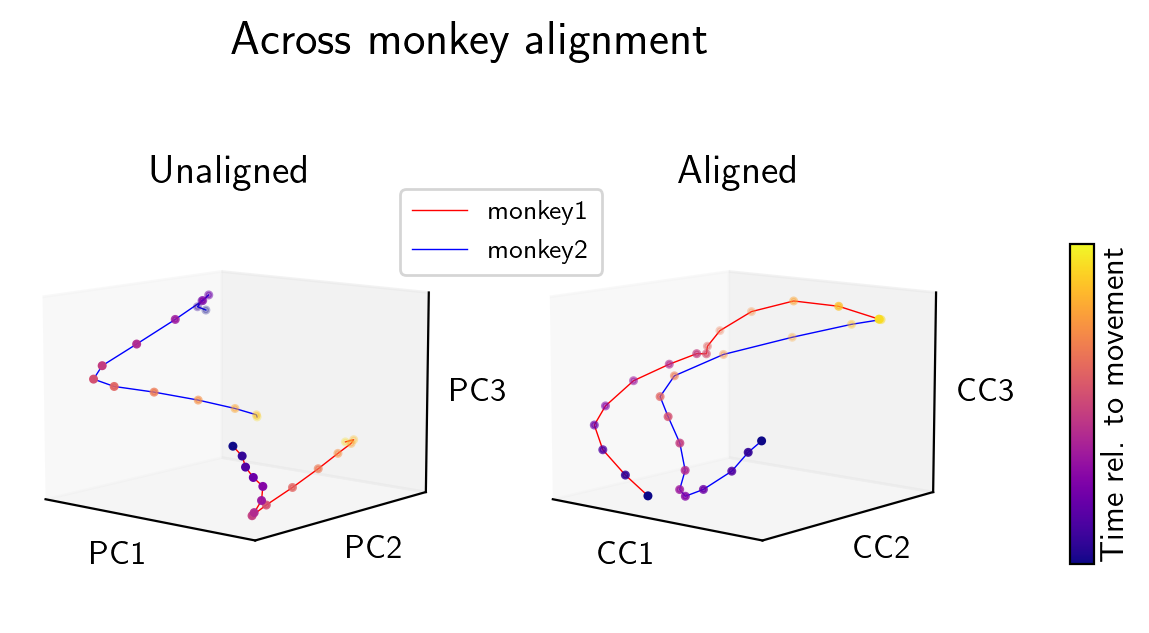

In [10]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,2,1, projection='3d',fc='None')
ax2 = fig.add_subplot(1,2,2, projection='3d',fc='None')
cax = fig.add_axes([1, 0.3, .02, 0.4])
axes = [ax,ax2]

target = 4
trial = 13

colors = utility.get_colors(n_time)
line_c=['r','b']
for i,ex in enumerate(ex_data):
    ax.scatter(ex[target,trial,:,0],ex[target,trial,:,1],ex[target,trial,:,2],
               c=colors, s=5)
    ax.plot(ex[target,trial,:,0],ex[target,trial,:,1],ex[target,trial,:,2],line_c[i],lw=.5)


data1 = np.reshape(ex_data[0,...], (-1,n_components))
data2 = np.reshape(ex_data[1,...], (-1,n_components))
*_,U,V = dt.canoncorr(data1, data2, fullReturn=True)
offset = (target*n_trial)*n_time + trial*n_time
ax2.scatter(U[offset:offset+n_time,0],U[offset:offset+n_time,1],U[offset:offset+n_time,2],
            c=colors, s=5)
l1=ax2.plot(U[offset:offset+n_time,0],U[offset:offset+n_time,1],U[offset:offset+n_time,2],
            line_c[0],lw=.5, label='monkey1')

ax2.scatter(V[offset:offset+n_time,0],V[offset:offset+n_time,1],V[offset:offset+n_time,2],
            c=colors, s=5)
l2=ax2.plot(V[offset:offset+n_time,0],V[offset:offset+n_time,1],V[offset:offset+n_time,2],
            line_c[1],lw=.5, label='monkey2')

titles=['Unaligned','Aligned']
labels = ['PC','CC']
for i, ax in enumerate(axes):
    ax.view_init(10,-50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f'{labels[i]}1', labelpad=-10)
    ax.set_ylabel(f'{labels[i]}2', labelpad=-10)
    ax.set_zlabel(f'{labels[i]}3', labelpad=-10)
    ax.set_title(titles[i], pad=0)
axes[0].legend(handles=[l1[0], l2[0]],loc=(.9,.8))
fig.colorbar(cm.ScalarMappable(cmap='plasma'),cax=cax,ax=ax, label='Time rel. to movement', ticks=[])

fig.suptitle('Across monkey alignment', fontsize = 'xx-large')
